*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Systems

In this chapter, we'll start with a classic word problem about ticket sales -- the kind you might have encountered in high school algebra.
We'll use SymPy to solve it quickly, and then we'll pull back the curtain to see how the solution works.

The key idea is to represent a system of equations as a **matrix equation**, which makes it possible to apply an algorithm called **Gauss-Jordan elimination**.
This algorithm uses simple row operations -- multiplying and subtracting equations -- to systematically eliminate variables and find solutions.

We'll work through the algorithm step by step, implementing it ourselves to see how it works.
By the end of the chapter, you'll understand one of the fundamental algorithms in linear algebra and see how it connects to the algebra you might have learned years ago.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/system.ipynb).

In [1]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate

In [4]:
from utils import set_precision

set_precision(3)

## Systems of Equations

If you studied algebra, you might have encountered dreaded word problems like this one:


> At a school play, 50 tickets were sold for a total of \$380. Tickets were priced as follows:
>
> - Child tickets: \$5  
> - Adult tickets: \$12  
> - Senior tickets: \$8  
>
> Each adult brought exactly two children with them, and no children attended without an adult.
>
> How many of each type of ticket were sold?

To answer questions like this, you were probably taught to define variables to represent the unknown quantities. For example, we'll define

- $c$ as the number of child tickets sold  
- $a$ as the number of adult tickets sold  
- $s$ as the number of senior tickets sold  

We can use SymPy to represent these variables with symbols.

In [5]:
c, a, s = sp.symbols('c a s')

Next we can write equations to represent the given relationships among the variable.
This equation represents the total number of tickets sold:

In [6]:
eq1 = sp.Eq(c + a + s, 50)
eq1

Eq(a + c + s, 50)

This one represents total sales.

In [7]:
eq2 = sp.Eq(5*c + 12*a + 8*s, 380)
eq2

Eq(12*a + 5*c + 8*s, 380)

And this one represents the constraint that every adult brings two children.

In [8]:
eq3 = sp.Eq(c, 2*a)
eq3

Eq(c, 2*a)

To solve these equations, we can use the SymPy function `linsolve`, which takes as parameters a list of equations and a list of unknowns. 

In [9]:
eqns = [eq1, eq2, eq3]
unknowns = [c, a, s]

sp.linsolve(eqns, unknowns)

{(20, 10, 20)}

The result is a set of solutions -- in this case there is only one: 20 children, 10 adults, and 20 seniors.

Now let's see how `linsolve` works.

## Matrix Equations

The algorithm `linsolve` uses is Gauss-Jordan elimination.
The first step is to write the system of equations as a matrix equation.
SymPy provides a function that extracts from the equations a matrix of coefficients and a vector of constants.

In [10]:
A, b = sp.linear_eq_to_matrix(eqns, unknowns)
A

Matrix([
[1,  1, 1],
[5, 12, 8],
[1, -2, 0]])

In [11]:
b

Matrix([
[ 50],
[380],
[  0]])

In this representation, the unknowns don't appear explicitly, but if we put the unknowns in a vector, `x`, we can write the equations in the form $Ax = b$.
So we can recover the original equations like this:

In [12]:
x = sp.Matrix(unknowns)
sp.Eq(A * x, b)

Eq(Matrix([
[       a + c + s],
[12*a + 5*c + 8*s],
[        -2*a + c]]), Matrix([
[ 50],
[380],
[  0]]))

Note that for a SymPy matrix, the `*` operator performs matrix multiplication.

The next step in Gauss-Jordan elimination is to form an **augmented matrix** with `b` appended to `A` as an additional column.

In [13]:
M = A.row_join(b)
M

Matrix([
[1,  1, 1,  50],
[5, 12, 8, 380],
[1, -2, 0,   0]])

Each row of the augmented matrix represents an equation with a left hand side and a right hand side.

In [14]:
row0 = M[0, :]
row0

Matrix([[1, 1, 1, 50]])

If we multiply both sides of the equation by a constant, the result is still a valid equation.

In [15]:
row0 * 5

Matrix([[5, 5, 5, 250]])

And if we add or subtract two equations, the result is a valid equation.

In [16]:
row1 = M[1, :] 
row1 - 5 * row0

Matrix([[0, 7, 3, 130]])

Notice that by subtracting rows in this way, we canceled out one of the coefficients, leaving a zero at the beginning of the row -- which means that this equation depends on one less variable.

Continuing in this way, we can use these row operations to cancel out one coefficient at a time.
We'll use the following function, which takes `M` and uses row `i` to eliminate the element in row `j`, column `k`.

In [17]:
def row_reduce(M, i, j, k):
    row_i = M[i, :]
    row_j = M[j, :]
    factor = row_j[k] / row_i[k]
    M[j, :] -= factor * row_i
    return factor

First we'll use row 0 to eliminate the first element in rows 1 and 2.

In [18]:
row_reduce(M, 0, 1, 0)
row_reduce(M, 0, 2, 0)
M

Matrix([
[1,  1,  1,  50],
[0,  7,  3, 130],
[0, -3, -1, -50]])

Next we'll use row 1 to eliminate the middle element in rows 0 and 2.

In [19]:
row_reduce(M, 1, 0, 1)
row_reduce(M, 1, 2, 1)
M

Matrix([
[1, 0, 4/7, 220/7],
[0, 7,   3,   130],
[0, 0, 2/7,  40/7]])

Next we'll use row 3 to eliminate the last element of rows 0 and 1.

In [20]:
row_reduce(M, 2, 1, 2)
row_reduce(M, 2, 0, 2)
M

Matrix([
[1, 0,   0,   20],
[0, 7,   0,   70],
[0, 0, 2/7, 40/7]])

Finally, we'll use this function to divide each row by its one remaining coefficient.

In [21]:
def normalize_rows(M):
    rows, cols = M.shape
    for i in range(rows):
        M[i, :] /= M[i, i]

In the result, the solution appears in the last column.

In [22]:
normalize_rows(M)
M

Matrix([
[1, 0, 0, 20],
[0, 1, 0, 10],
[0, 0, 1, 20]])

We can split the augmented matrix into a square matrix and a solution vector.

In [23]:
I = M[:, :-1]
sol = M[:, -1]

Here's the solution displayed as a vector equation.

In [24]:
sp.Eq(I * x, sol)

Eq(Matrix([
[c],
[a],
[s]]), Matrix([
[20],
[10],
[20]]))

I called the reduced matrix `I` because that's the conventional name for the identity matrix.
If we multiply `I` by any vector, the result is the same vector.

In [25]:
I * x

Matrix([
[c],
[a],
[s]])

And if we multiply by any matrix, the result is the same matrix.

In [26]:
I * A

Matrix([
[1,  1, 1],
[5, 12, 8],
[1, -2, 0]])

Gauss-Jordan elimination is just one way to solve a matrix equation.
Let's look at another.

## Matrix Inversion

Suppose you want to solve an equation like $ax = b$, where $a$ and $b$ are scalars.
If you divide both sides by $a$, the result is $x = b/a$, which is considered a solution because we know how to do scalar division.

Unfortunately, we can't do the same thing with a matrix equation like $Ax = b$ because there's no general definition for matrix division.
But we can avoid division using inverse multiplication.
In the scalar equation, that means multiplying both sides by $1/a$, also denoted $a^{-1}$.

$$a^{-1} a x = a^{-1} b$$

On the left side, $a^{-1} a = 1$, so we have

$$x = a^{-1} b$$

We can do the same thing with the matrix equation.
If we can find the inverse of $A$, denoted $A^{-1}$, we can multiply both sides of the matrix equation to get:

$$A^{-1} A x = A^{-1} b$$

On the left side, the product $A^{-1} A$ is the identity matrix $I$, and we have already seen that $I x = x$, so the result is

$$x = A^{-1} b$$

And that's considered a solution because we know how to do matrix multiplication.

Now all we have to do is find $A^{-1}$.
SciPy provides a function that does it.

In [27]:
from scipy.linalg import inv

A_inv = A.inv()
A_inv

Matrix([
[  8,   -1,   -2],
[  4, -1/2, -3/2],
[-11,  3/2,  7/2]])

We can confirm that $A^{-1} A = I$.

In [28]:
A_inv * A

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

And we can find a solution by evaluating the right hand side, $A^{-1} b$.

In [29]:
A_inv * b

Matrix([
[20],
[10],
[20]])

That solution should look familiar.

There are several ways to find the inverse of a matrix.
One is to write the matrix equation $A A^{-1} = I$ and use Gauss-Jordan elimination to solve for $A^{-1}$.

In [30]:
M = A.row_join(I)
M

Matrix([
[1,  1, 1, 1, 0, 0],
[5, 12, 8, 0, 1, 0],
[1, -2, 0, 0, 0, 1]])

In [31]:
def gauss_jordan_elimination(M):
    rows, cols = M.shape
    for i in range(rows):
        for j in range(rows):
            if i != j:
                row_reduce(M, i, j, i)

In [32]:
gauss_jordan_elimination(M)
M

Matrix([
[1, 0,   0,     8,   -1,    -2],
[0, 7,   0,    28, -7/2, -21/2],
[0, 0, 2/7, -22/7,  3/7,     1]])

In [33]:
normalize_rows(M)
M

Matrix([
[1, 0, 0,   8,   -1,   -2],
[0, 1, 0,   4, -1/2, -3/2],
[0, 0, 1, -11,  3/2,  7/2]])

The result is an augmented matrix that contains $I$ on the left and $A^{-1}$ on the right.

So that's one way to find the inverse of a matrix, but `inv` uses a different algorithm, called LU decomposition.

## LU Decomposition

Let's see what LU decomposition is, why it is useful, and how we compute it.

In general, a **decomposition** of a matrix, $A$, is a set of matrices whose product is $A$.
More specifically, an LU decomposition is two matrices, $L$ and $U$, where $L U = A$, and

* $L$ is a lower triangular matrix, and 
* $U$ is an upper triangular matrix.

I'll explain what that means below.
SciPy matrices have a method that computes an LU decomposition.

In [34]:
L, U, perm = A.LUdecomposition()

We can confirm that $L U = A$.

In [35]:
sp.Eq(L * U, A)

True

`L` is lower triangular, which means all of the non-zero elements are on or below the main diagonal.

In [36]:
L

Matrix([
[1,    0, 0],
[5,    1, 0],
[1, -3/7, 1]])

And `U` is upper triangular, which means all of the non-zero elements are on or above the main diagonal.

In [37]:
U

Matrix([
[1, 1,   1],
[0, 7,   3],
[0, 0, 2/7]])

`LUdecomposition` sometimes permutes (swaps) the rows of the matrix, so it returns a third value, `perm`, which is a list of pairs, where each pair contains the indices of two rows that were swapped.

In this example, `perm` is an empty list, meaning that there were no swaps.
So we'll ignore this detail for now.

In [38]:
perm

[]

LU decomposition is useful because it provides an efficient way to solve a matrix equation -- and it is numerically stable, which means that it can compute the solution more precisely than multiplication by a matrix inverse.

If we have $L$ and $U$ such that $L U = A$, and we want to solve $A x = b$, we can do it by rewriting the matrix equation as $L U x = b$, and substituting in $y$ for $U x$.
Then we

* Solve $L y = b$ for $y$, and

* Solve $U x = y$ for $x$.

Here's the first step:

In [39]:
y = L.solve(b)
y

Matrix([
[  50],
[ 130],
[40/7]])

And here's the second:

In [40]:
x = U.solve(y)
x

Matrix([
[20],
[10],
[20]])

That result should look familiar.
This process is efficient because the `solve` methods provided by `L` and `U` provide take advantage of their structure, so the number of row operations is minimized.

Now here's a function that computes an LU decomposition.

In [41]:
def LUdecomposition(A):
    rows, cols = A.shape
    U = A.copy()
    L = sp.eye(rows)
    
    for i in range(rows):
        for j in range(rows):
            if i < j:
                L[j, i] = row_reduce(U, i, j, i)

    return L, U

The function starts with a copy of `A`, which we will transform into `U`, and a new identity matrix, which we will transform into `L`.

The process is similar to Gauss-Jordan elimination, but we only eliminate the coefficients below the main diagonal.
At each step, we eliminate one coefficient from `U` and store the multiplicative factors, returned from `row_reduce`, in the lower triangle of `L`.

We'll test it by computing the decomposition of `A` again.

In [42]:
L, U = LUdecomposition(A)
L

Matrix([
[1,    0, 0],
[5,    1, 0],
[1, -3/7, 1]])

In [43]:
U

Matrix([
[1, 1,   1],
[0, 7,   3],
[0, 0, 2/7]])

Those results should look familiar.

LU decomposition is the most common method for solving systems of linear equations.
But it is inefficient to solve large systems symbolically, as we did with SymPy.
It is more common to solve linear systems numerically.

## Numerical Solution

NumPy has a `linalg` module that provides functions related to linear algebra.
Before we can use it, we have to convert `A` and `b` from SymPy `Matrix` objects to NumPy arrays.

In [44]:
A_np = np.array(A).astype(float)
A.shape

(3, 3)

In [45]:
b_np = np.array(b).astype(float).flatten()
b.shape

(3, 1)

The NumPy function `solve` uses LU decomposition to solve matrix equations.

In [46]:
np.linalg.solve(A_np, b_np)

array([20., 10., 20.])

If you want to solve several equations with the same matrix, `A`, and different right hand sides, `b`, it is more efficient to compute the LU decomposition once.
We can't do that with NumPy, but we can with SciPy.
The function `lu` returns `L`, `U`, and the permutation matrix, `P`.

In [47]:
from scipy.linalg import lu

P, L, U = lu(A_np)

We can use `P`, `L`, and `U` to solve the equation, but it is more convenient to use the helper functions `lu_factor` and `lu_solve`.

In [48]:
from scipy.linalg import lu_factor, lu_solve

LU, piv = lu_factor(A_np)
LU

array([[ 5.   , 12.   ,  8.   ],
       [ 0.2  , -4.4  , -1.6  ],
       [ 0.2  ,  0.318, -0.091]])

`lu_factor` returns a single array that contains the non-zero elements of both `L` and `U` (omitting the diagonal of `L`, which is all ones).
And it returns a pivot array that represents the permutation matrix in compact form.

In [49]:
piv

array([1, 2, 2], dtype=int32)

We don't need to worry too much about unpacking these structures -- we can just pass them as arguments to `lu_solve`.

In [50]:
lu_solve((LU, piv), b_np)

array([20., 10., 20.])

Both NumPy and SciPy use functions from LAPACK, an open-source library of linear algebra function written in Fortran in the late 1980s and early 1990s.

At this point we have solved the same small matrix equations about ten different ways.
Let's move on to something more interesting!

## Circuit Analysis

Systems of equations are useful for more than contrived word problems.
As an example, we'll use them to analyze an electrical circuit.
We'll use NetworkX to build a graph that represents the circuit.
From the graph we'll generate a system of equations that represent a physical model of the circuit.
Then we'll solve the equations.

The following function makes an empty graph and initializes the variables we'll use to keep track of constants and unknowns.
In this example, the constants are resistances and the unknowns are voltages and currents.

In [51]:
def make_graph():
    G = nx.DiGraph()
    G.graph['constants'] = []
    G.graph['unknowns'] = []
    return G

The following functions create SymPy symbols to represent constants and unknowns.

In [52]:
def make_constant(G, name, **kwargs):
    symbol = sp.Symbol(name)
    G.graph['constants'].append(symbol)
    return symbol

In [53]:
def make_unknown(G, name, **kwargs):
    symbol = sp.Symbol(name)
    G.graph['unknowns'].append(symbol)
    return symbol

The following function creates a graph that represents a voltage divider, a simple circuit that contains two resistors.

In [54]:
def make_voltage_divider():
    G = make_graph()
    G.graph['fixed'] = ['in', 'gnd']
    
    G.add_edge('in', 'out', component='R', name='R1')
    G.add_edge('out', 'gnd', component='R', name='R2')

    add_symbols(G)
    return G

The following function traverses a graph:

* To every edge it adds a constant resistance and an unknown current.

* To every node it adds a voltage, either constant or unknown.

In [55]:
def add_symbols(G):
    for u, v, data in G.edges(data=True):
        name = data['name']
        data['resistance'] = make_constant(G, name)
        data['current'] = make_unknown(G, f"I_{name}")

    for node, data in G.nodes(data=True):
        if node in G.graph['fixed']:
            data['voltage'] = make_constant(G, f"V_{node}")
        else:
            data['voltage'] = make_unknown(G, f"V_{node}")

Now we'll make a graph that represents a voltage divider.

In [56]:
G = make_voltage_divider()

`draw_circuit_graph` uses NetworkX functions to draw the circuit.

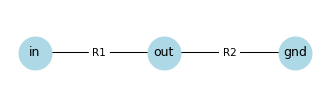

In [57]:
from utils import draw_circuit_graph

plt.figure(figsize=(4.5, 1.5))
draw_circuit_graph(G)

The node labeled `in` represents the input to the circuit, which is a known voltage.
The node labeled `gnd` represents electrical ground, which is a known voltage usually defined to be 0.
The node labeled `out` represents the output of the circuit, which is the unknown voltage we will compute.

To write a system of equations, we will use two laws that model the behavior of electricity in a circuit.
The first is Ohm's law, which states that the current through a resistor, `I`, depends on its resistance, `R`, and the difference in the voltage of the nodes it's connected to, `V1` and `V0`.
So for each resistor in the circuit, we can write the equation `V1 - V0 = I * R`.

The following function traverses the graph and returns a list of equations, one for each resistor.

In [58]:
def make_ohm_equations(G):
    ohm_eqs = []
    
    for u, v, data in G.edges(data=True):
        if data['component'] == 'R':
            V1 = G.nodes[u]['voltage']
            V0 = G.nodes[v]['voltage']
            R = data['resistance']
            I = data['current']
            
            eq = sp.Eq(V1 - V0, I * R)
            ohm_eqs.append(eq)
            
    return ohm_eqs

Here are the equations from the circuit divider.

In [59]:
ohm_eqs = make_ohm_equations(G)

We'll use this function to display them.

In [60]:
from IPython.display import display

def display_equations(eqs):
    for eq in eqs:
        display(eq)

In [61]:
display_equations(ohm_eqs)

Eq(V_in - V_out, I_R1*R1)

Eq(-V_gnd + V_out, I_R2*R2)

The second law we'll use is Kirchhoff's junction rule, which says that in any junction in a circuit -- or node in our graph -- the total current that flows in must equal the total current that flows out.
The following function traverses the graph and returns a list of equations, one for each node.

In [62]:
def make_kcl_equations(G):
    kcl_eqs = []
    
    for node in G.nodes:
        if node in G.graph['fixed']:
            continue

        expr_out = sum(data['current'] for _, _, data in G.out_edges(node, data=True))
        expr_in = sum(data['current'] for _, _, data in G.in_edges(node, data=True))
        eq = sp.Eq(expr_in, expr_out)
        
        kcl_eqs.append(eq)
        
    return kcl_eqs

In [63]:
kcl_eqs = make_kcl_equations(G)

display_equations(kcl_eqs)

Eq(I_R1, I_R2)

We can use `linear_eq_to_matrix` to convert this system of equations to a matrix equation.

In [64]:
eqs = ohm_eqs + kcl_eqs
A, b = sp.linear_eq_to_matrix(eqs, G.graph['unknowns'])
A

Matrix([
[-R1,   0, -1],
[  0, -R2,  1],
[  1,  -1,  0]])

In [65]:
b

Matrix([
[-V_in],
[V_gnd],
[    0]])

And we can use the solve method to solve it.

In [66]:
solution_vector = A.LUsolve(b)
solution_vector.simplify()

And here's the solution.

In [67]:
sp.Eq(sp.Matrix(G.graph['unknowns']), solution_vector)

Eq(Matrix([
[ I_R1],
[ I_R2],
[V_out]]), Matrix([
[     (-V_gnd + V_in)/(R1 + R2)],
[     (-V_gnd + V_in)/(R1 + R2)],
[(R1*V_gnd + R2*V_in)/(R1 + R2)]]))

Because we solved the system symbolically, the results are equations that relate the unknowns on the left to the known constants on the right.

If we have numerical quantities for the constants, we can substitute them into the equations to get numerical results.
For example, suppose $R_1$ and $R_2$ are 1000 and 4000 ohms, and $V_{in}$ and $V_{gnd}$ are 5 and 0 volts.

In [68]:
subs = dict(zip(G.graph['constants'], [1000, 4000, 5, 0]))
subs

{R1: 1000, R2: 4000, V_in: 5, V_gnd: 0}

Here are the results.

In [69]:
evaluated = solution_vector.subs(subs)
evaluated

Matrix([
[1/1000],
[1/1000],
[     4]])

The current through both resistors is 1 milliamp, and `V_{out}` is 4 volts.
If you have studied the analysis of circuits, you might have been able to compute these values in your head.
So let's try something a little more challenging.

## R2R Ladder

The following function makes a graph that represents a circuit called an R2R ladder, which can be used as a simple digital-to-analog converter -- that is, it can convert an $N$-bit binary number to an analog voltage with `2^N` possible values.
I'll explain that more carefully below.

In [70]:
def make_r2r_ladder(N):
    G = make_graph()
    G.graph['fixed'] = [f'D{i}' for i in range(N)] + ['gnd']  

    start = 'gnd'
    for i in range(N):
        node = f'n{i}'
        pin = f'D{i}'
        G.add_edge(start, node, component='R', name=f'r{i}')
        G.add_edge(pin, node, component='R', name=f'R{i}')
        start = node
    
    G['gnd']['n0']['name'] = 'R'
    add_symbols(G)
    return G

Here's a ladder with three input values.

In [71]:
N = 3
G2 = make_r2r_ladder(N)

And here's a graph representation of the circuit.

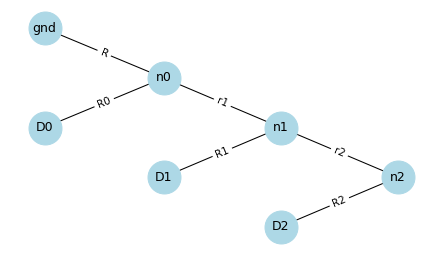

In [72]:
draw_circuit_graph(G2)

`D0`, `D1`, and `D2` are digital inputs, so each one is meant to be either a "high" voltage like 4 volts, or a "low" voltage like 0 volts, and nothing in between.
Each input represents a bit of a binary number.

The output of the circuit is at `n2` -- at this node, the voltage can be one of eight values between 0 V and 4 V.
If all three inputs are low, the output should be 0 V.
If all three are high, the output should be close to 4 V.

We will specify that the inputs and `gnd` are fixed nodes.

In [73]:
G2.graph['fixed']

['D0', 'D1', 'D2', 'gnd']

So the voltages at these nodes are constants, along with the resistance of the resistors.

In [74]:
constants = G2.graph['constants']
constants

[R, r1, R0, r2, R1, R2, V_gnd, V_D0, V_D1, V_D2]

The unknowns are the currents through the resistors and the voltages of the nodes that are not fixed.

In [75]:
unknowns = G2.graph['unknowns']
unknowns

[I_R, I_r1, I_R0, I_r2, I_R1, I_R2, V_n0, V_n1, V_n2]

With that, we can write a system of equations that relates the unknowns and the constants.

In [76]:
ohm_eqs = make_ohm_equations(G2)
kcl_eqs = make_kcl_equations(G2)

for eqn in ohm_eqs:
    display(eqn)

for eqn in kcl_eqs:
    display(eqn)

Eq(V_gnd - V_n0, I_R*R)

Eq(V_n0 - V_n1, I_r1*r1)

Eq(V_D0 - V_n0, I_R0*R0)

Eq(V_n1 - V_n2, I_r2*r2)

Eq(V_D1 - V_n1, I_R1*R1)

Eq(V_D2 - V_n2, I_R2*R2)

Eq(I_R + I_R0, I_r1)

Eq(I_R1 + I_r1, I_r2)

Eq(I_R2 + I_r2, 0)

And we can rewrite the system of equations as a matrix equation.

In [77]:
eqs = ohm_eqs + kcl_eqs
A, b = sp.linear_eq_to_matrix(eqs, unknowns)
A

Matrix([
[-R,   0,   0,   0,   0,   0, -1,  0,  0],
[ 0, -r1,   0,   0,   0,   0,  1, -1,  0],
[ 0,   0, -R0,   0,   0,   0, -1,  0,  0],
[ 0,   0,   0, -r2,   0,   0,  0,  1, -1],
[ 0,   0,   0,   0, -R1,   0,  0, -1,  0],
[ 0,   0,   0,   0,   0, -R2,  0,  0, -1],
[ 1,  -1,   1,   0,   0,   0,  0,  0,  0],
[ 0,   1,   0,  -1,   1,   0,  0,  0,  0],
[ 0,   0,   0,   1,   0,   1,  0,  0,  0]])

In [78]:
b

Matrix([
[-V_gnd],
[     0],
[ -V_D0],
[     0],
[ -V_D1],
[ -V_D2],
[     0],
[     0],
[     0]])

We can use the `LUsolve` method to solve the matrix equation.

In [79]:
solution_vector = A.LUsolve(b)

The results are complicated. For example, here the expression for the output voltage at `n2`.

In [80]:
V_n2 = solution_vector[-1]

if N < 5:
    display(V_n2.simplify())

(R*R0*R1*V_D2 + R*R0*R2*V_D1 + R*R1*R2*V_D0 + R0*R1*R2*V_gnd + V_D2*r2*(R*R0 + (R + R0)*(R1 + r1)) + r1*(R + R0)*(R1*V_D2 + R2*V_D1))/(R*R0*R1 + R1*r1*(R + R0) + (R2 + r2)*(R*R0 + (R + R0)*(R1 + r1)))

In the general case where the input voltages and resistances can have any values, the results are complicated.
But this circuit is usually constructed with only two resistances, `r` and `R`, where `R = 2r` -- hence the name R2R.
And the input voltages are either a designated low or high value, nothing in between.

The following function takes values for `r` and `R`, and low and high voltages, and returns a dictionary we'll use to replace the constants in the equations with numbers.

In [81]:
def set_values(constants, **values):
    subs = {}
    for symbol in constants:
        for key, value in values.items():
            if symbol.name.startswith(key):
                subs[symbol] = value
    
    return subs

Here are the substitutions where `r` is 10,000 ohms, `R` is 20,000 ohms, ground is 0 V, and the high voltage is 4 V. 

In [82]:
subs = set_values(constants, r=10000, R=20000, V_gnd=0, V_D=4)
subs

{R: 20000,
 r1: 10000,
 R0: 20000,
 r2: 10000,
 R1: 20000,
 R2: 20000,
 V_gnd: 0,
 V_D0: 4,
 V_D1: 4,
 V_D2: 4}

Here's the output voltage at `n2`.

In [83]:
V_n2.subs(subs)

7/2

In general, if there are `N` inputs and all are at the high voltage, we can compute the output voltage like this.

In [84]:
4 * (2**N-1) / 2**N

3.500

If you go back and run this analysis again with increasing values of `N`, you should find that the output voltage gets closer to 4 V.
Also try it with different combinations of input voltages.

## Exercises

### Exercise

If you construct the R2R ladder with larger values of `N`, you will find that it takes longer to solve and the results get complicated.

Rather than analyze a circuit symbolically, and then substitute numerical values at the end, it is more efficient to substitute values into the matrix equation and solve it numerically.

Substitute values into `A` and `b`, convert them to NumPy arrays, and use the NumPy solver to solve the system numerically.
Is the solution the same, within floating-point approximation?

array([[-1.312e-04],
       [-6.250e-05],
       [ 6.875e-05],
       [-2.500e-05],
       [ 3.750e-05],
       [ 2.500e-05],
       [ 2.625e+00],
       [ 3.250e+00],
       [ 3.500e+00]])

### Exercise

A quarter bridge is a simple circuit often used with sensitive sensors like strain gauges.
The following function makes a graph that represents this circuit.

For more on how this works, see [Measuring Strain with Strain Gages](https://www.ni.com/en/shop/data-acquisition/sensor-fundamentals/measuring-strain-with-strain-gages.html)

In [87]:
def make_quarter_bridge():
    G = make_graph()
    G.graph['fixed'] = ['plus', 'minus']
    
    # One active strain gauge and three fixed resistors
    G.add_edge('plus', 'B', component='R', name='R1')
    G.add_edge('minus', 'B', component='R', name='R2')
    G.add_edge('minus', 'A', component='R', name='R3')
    G.add_edge('plus', 'A', component='R', name='R4')

    add_symbols(G)
    return G

Here's what it looks like.
Generally `R1`, `R2`, and `R3` are the same resistance, and `R4` is a strain gauge whose resistance varies depending on the strain (stretching or compression) of a mechanical element.

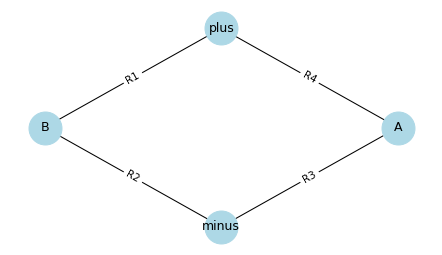

In [88]:
G3 = make_quarter_bridge()
pos = {
    'plus': (0, 1),
    'minus': (0, -1),
    'A': (1, 0),
    'B': (-1, 0)
}
draw_circuit_graph(G3, pos=pos)

Use `make_ohm_equations` and `make_kcl_equations` to construct equations that model this circuit.
Then use `linear_eq_to_matrix` to convert the system of equations to a matrix equation, and the `LUsolve` method to solve it.

Substitute in the values `R1=1000`, `R2=1000`, `R3=1000`, `V_plus=5`, and `V_minus=0`.
Leave the value of `R4` as a symbolic constant.
How does the output voltage depend on `R4`?

[I_R1, I_R4, I_R2, I_R3, V_B, V_A]

((R1 + R2)*(R3*V_plus + R4*V_minus) - (R3 + R4)*(R1*V_minus + R2*V_plus))/((R1 + R2)*(R3 + R4))

5*(1000 - R4)/(2*(R4 + 1000))

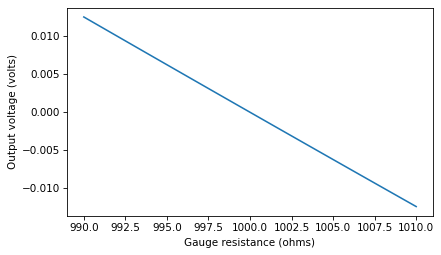

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)